General goal: Use transfer learning to speed up training of a model to predict the wind severity based on images of the surface of water.

data: https://www.kaggle.com/datasets/umairatwork/mu-ssid

In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
#locate where are data is at
#data is already split into train, test, and validation sets
testDir = "data/224x224/224x224/Testing"
trainDir = "data/224x224/224x224/Training"
valDir = "data/224x224/224x224/Validation"

In [3]:
#create datasets of our images
trainDS = tf.keras.utils.image_dataset_from_directory(
    trainDir,
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode = 'categorical')

testDS = tf.keras.utils.image_dataset_from_directory(
    testDir,
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode = 'categorical')

valDS = tf.keras.utils.image_dataset_from_directory(
    valDir,
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode = 'categorical')

Found 72000 files belonging to 4 classes.
Found 4800 files belonging to 4 classes.
Found 24000 files belonging to 4 classes.


Training on all included files would take a quite a long time. One of the benefits of transfer learning is that we should be able to use less data, so before we train we can subset our data and use less of it. Then we can compare the transfer learning model vs. the same archetecture without transfer learning to see if our pre-trained weights improved or increased the speed of learning.

In [4]:
#set our data to autotune image loading so disk i/o doesn't slow training
AUTOTUNE = tf.data.AUTOTUNE

trainDS = trainDS.take(int(72000 * .002))
valDS = valDS.take(int(24000 * .002))
testDS = testDS.take(int(4800 * .01))

trainDS = trainDS.prefetch(buffer_size=AUTOTUNE)
valDS = valDS.prefetch(buffer_size=AUTOTUNE)
testDS = testDS.prefetch(buffer_size=AUTOTUNE)

In [5]:
preprocessing = tf.keras.applications.convnext.preprocess_input

In [6]:
base = tf.keras.applications.ConvNeXtTiny(include_top=False,input_shape=(224,224,3))
base.trainable = False
base.summary()

Model: "convnext_tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_tiny_prestem_normaliz  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_tiny_stem (Sequential  (None, 56, 56, 96)  4896        ['convnext_tiny_prestem_normaliza
 )                                                               tion[0][0]']         

 tf.__operators__.add_2 (TFOpLa  (None, 56, 56, 96)  0           ['tf.__operators__.add_1[0][0]', 
 mbda)                                                            'convnext_tiny_stage_0_block_2_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_tiny_downsampling_blo  (None, 28, 28, 192)  74112      ['tf.__operators__.add_2[0][0]'] 
 ck_0 (Sequential)                                                                                
                                                                                                  
 convnext_tiny_stage_1_block_0_  (None, 28, 28, 192)  9600       ['convnext_tiny_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_0[0][0]']                      
                                                                                                  
 convnext_

 convnext_tiny_downsampling_blo  (None, 14, 14, 384)  295680     ['tf.__operators__.add_5[0][0]'] 
 ck_1 (Sequential)                                                                                
                                                                                                  
 convnext_tiny_stage_2_block_0_  (None, 14, 14, 384)  19200      ['convnext_tiny_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_1[0][0]']                      
                                                                                                  
 convnext_tiny_stage_2_block_0_  (None, 14, 14, 384)  768        ['convnext_tiny_stage_2_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_tiny_stage_2_block_0_  (None, 14, 14, 1536  591360     ['convnext_tiny_stage_2_block_0_l
 pointwise

 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_tiny_stage_2_block_3_  (None, 14, 14, 1536  591360     ['convnext_tiny_stage_2_block_3_l
 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_tiny_stage_2_block_3_  (None, 14, 14, 1536  0          ['convnext_tiny_stage_2_block_3_p
 gelu (Activation)              )                                ointwise_conv_1[0][0]']          
                                                                                                  
 convnext_tiny_stage_2_block_3_  (None, 14, 14, 384)  590208     ['convnext_tiny_stage_2_block_3_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
          

 convnext_tiny_stage_2_block_6_  (None, 14, 14, 384)  590208     ['convnext_tiny_stage_2_block_6_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
                                                                                                  
 convnext_tiny_stage_2_block_6_  (None, 14, 14, 384)  384        ['convnext_tiny_stage_2_block_6_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_tiny_stage_2_block_6_  (None, 14, 14, 384)  0          ['convnext_tiny_stage_2_block_6_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_12 (TFOpL  (None, 14, 14, 384)  0          ['tf.__operators__.add_11[0][0]',
 ambda)   

                                                                                                  
 convnext_tiny_stage_3_block_0_  (None, 7, 7, 768)   0           ['convnext_tiny_stage_3_block_0_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 7, 7, 768)   0           ['convnext_tiny_downsampling_bloc
 ambda)                                                          k_2[0][0]',                      
                                                                  'convnext_tiny_stage_3_block_0_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_tiny_stage_3_block_1_  (None, 7, 7, 768)   38400       ['tf.__operators__.add_15[0][0]']
 depthwise

In [7]:
inputs = tf.keras.Input(shape=(224,224,3))
x = preprocessing(inputs)
x = base(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
preModel = tf.keras.Model(inputs,outputs)

preModel.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
preModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 convnext_tiny (Functional)  (None, 7, 7, 768)         27820128  
                                                                 
 global_average_pooling2d (G  (None, 768)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 3076      
                                                                 
Total params: 27,823,204
Trainable params: 3,076
Non-trainable params: 27,820,128
_________________________________________________________________


In [9]:
preHistory = preModel.fit(trainDS, epochs = 3, validation_data = valDS)

Epoch 1/3
144/144 [==============================] - 2663s 18s/step - loss: 0.5654 - accuracy: 0.8077 - val_loss: 0.4413 - val_accuracy: 0.8327
Epoch 2/3
144/144 [==============================] - 2599s 18s/step - loss: 0.2906 - accuracy: 0.9099 - val_loss: 0.3548 - val_accuracy: 0.8509
Epoch 3/3
144/144 [==============================] - 2437s 17s/step - loss: 0.2201 - accuracy: 0.9379 - val_loss: 0.3289 - val_accuracy: 0.8698


In [10]:
base = tf.keras.applications.ConvNeXtTiny(weights=None, include_top=False, input_shape=(224,224,3))
base.trainable = True

inputs = tf.keras.Input(shape=(224,224,3))
x = preprocessing(inputs)
x = base(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs,outputs)

model.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
history = model.fit(trainDS, epochs = 3, validation_data = valDS)

Epoch 1/3
144/144 [==============================] - 6412s 44s/step - loss: 1.1587 - accuracy: 0.5879 - val_loss: 0.9598 - val_accuracy: 0.5944
Epoch 2/3
144/144 [==============================] - 6459s 45s/step - loss: 0.6798 - accuracy: 0.7138 - val_loss: 0.7971 - val_accuracy: 0.6699
Epoch 3/3
144/144 [==============================] - 43208s 302s/step - loss: 0.5483 - accuracy: 0.7771 - val_loss: 0.7584 - val_accuracy: 0.6882


In [12]:
#graphing method taken from https://www.tensorflow.org/tutorials/images/transfer_learning
def graphTraining(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

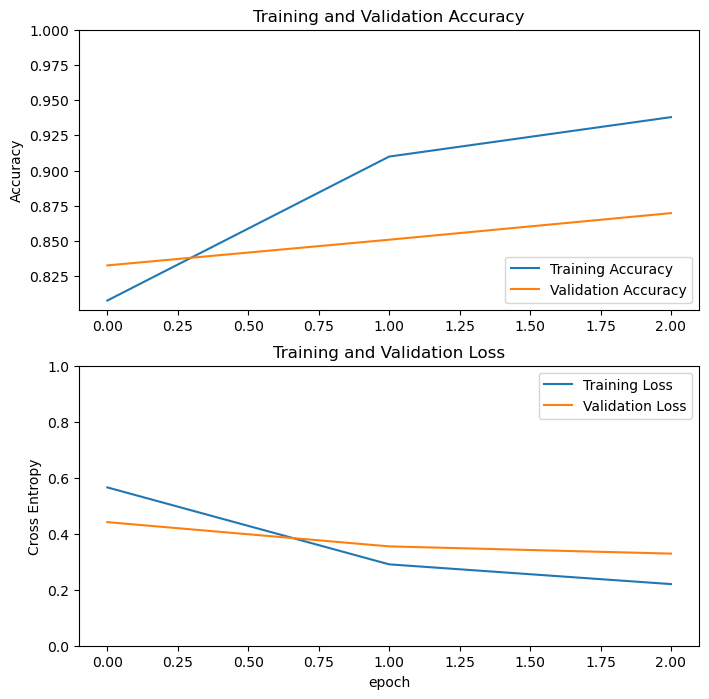

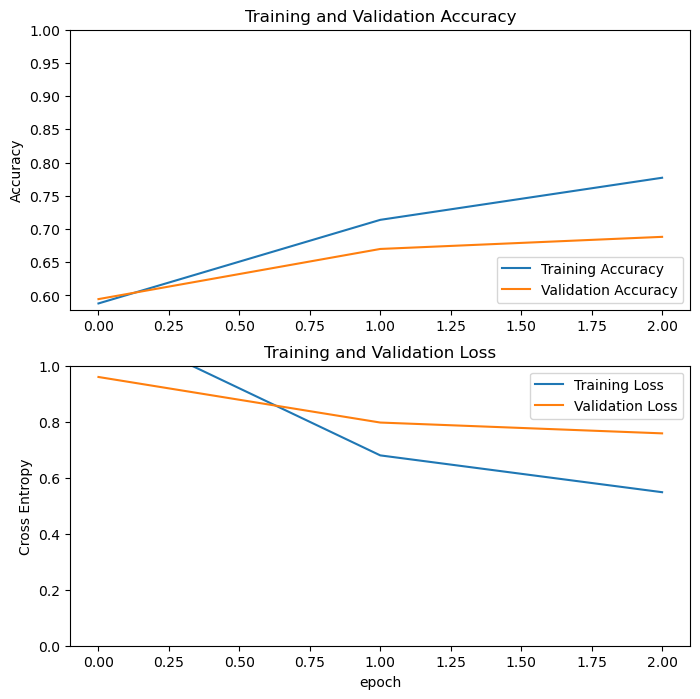

In [13]:
#compare the two models training
graphTraining(preHistory)
graphTraining(history)

In [14]:
#evaluate on testing data
testLoss, testAcc = preModel.evaluate(testDS, verbose=2)
testLoss, testAcc = model.evaluate(testDS, verbose=2)

48/48 - 638s - loss: 0.5594 - accuracy: 0.7383 - 638s/epoch - 13s/step
48/48 - 637s - loss: 0.8362 - accuracy: 0.6706 - 637s/epoch - 13s/step


The model with pre-trained weights ended with higher accuracy than the model with random weights, and notably took ~1/5th the amount of time to train. Model accuracy could no doubt be improved greatly for each model by using the whole training set, but we can see that for using small datasets, pre-trained weights can not only improve training speed, but also improve model performance.